In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!nvidia-smi
!nvcc --version

Sat Mar  1 04:36:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!git clone https://github.com/pallets/flask.git
!pip install scipy matplotlib scipy nx-arangodb arango
!pip install nx-cugraph-cu12 --extra-index-url https://pypi.nvidia.com # Requires CUDA-capable GPU
!pip install --upgrade langchain langchain-community langchain-openai langgraph
!pip install langchain_mistralai

Cloning into 'flask'...
remote: Enumerating objects: 25360, done.
remote: Total 25360 (delta 0), reused 0 (delta 0), pack-reused 25360 (from 1)
Receiving objects: 100% (25360/25360), 10.38 MiB | 12.78 MiB/s, done.
Resolving deltas: 100% (16988/16988), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.5/343.5 kB 19.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 7.7 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.6/114.6 kB 8.6 MB/s eta 0:00:00
  Created wheel for arango: filename=arango-0.2.1-py3-none-any.whl size=202695 sha256=40c0bff0d3cd6a6e7e9ff9b7c3f13233a2f5912991d594252258cbce4e0c1c49
  Stored in directory: /root/.cache/pip/wheels/9e/0c/5c/a697647a3b83e07efa8deabb3c320f1c1e7cf2b10652eb3183
Successfully built arango
  Attemptin

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import os
import ast
from typing import Dict, Set, List, Tuple, Optional,Any
import json
from arango import ArangoClient
import nx_arangodb as nxadb
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tool
import re

[04:37:38 +0000] [INFO]: NetworkX-cuGraph is available.


### Building graph

In [6]:
import os
import ast
import networkx as nx
from typing import Dict, Set, List
import json
from arango import ArangoClient
os.environ["MISTRAL_API_KEY"]="jJAuJZkjVcy2ynUhan375sHNviHiBeJU"

class CodebaseVisualizer:
    def __init__(self, root_dir: str):
        self.root_dir = root_dir
        self.graph = nx.DiGraph()
        self.file_contents: Dict[str, str] = {}
        self.import_relations: Dict[str, Set[str]] = {}
        self.module_symbols: Dict[str, Dict[str, Dict[str, int]]] = {}  # file -> {symbol -> {type, line_no}}
        self.file_index: Dict[str, int] = {}  # Maps files to indices
        self.current_index = 0
        self.directories: Set[str] = set()

    def _get_next_index(self) -> int:
        """Get next available index for file indexing."""
        self.current_index += 1
        return self.current_index

    def _chunk_code(self, code: str, lines_per_chunk: int = 20) -> List[Dict]:
        """
        Chunk the given code into snippets.
        Returns a list of dictionaries with 'code_snippet', 'start_line', and 'end_line'.
        """
        lines = code.splitlines()
        chunks = []
        for i in range(0, len(lines), lines_per_chunk):
            chunk_lines = lines[i:i + lines_per_chunk]
            chunk = {
                'code_snippet': '\n'.join(chunk_lines),
                'start_line': i + 1,
                'end_line': i + len(chunk_lines)
            }
            chunks.append(chunk)
        return chunks

    def parse_files(self) -> None:
        """Parse all Python files in the directory and build relationships."""
        # First pass: Index all files and create directory nodes
        for root, dirs, files in os.walk(self.root_dir):
            # Add directory node
            rel_dir = os.path.relpath(root, self.root_dir)
            if rel_dir != '.':
                self.directories.add(rel_dir)
                self.graph.add_node(rel_dir, type='directory')

            # Index Python files
            for file in files:
                if file.endswith('.py'):
                    file_path = os.path.join(root, file)
                    rel_path = os.path.relpath(file_path, self.root_dir)
                    self.file_index[rel_path] = self._get_next_index()
                    
                    try:
                        with open(file_path, 'r', encoding='utf-8') as f:
                            content = f.read()
                            self.file_contents[rel_path] = content
                            self._analyze_file(rel_path, content)
                    except Exception as e:
                        print(f"Error parsing {file_path}: {e}")

    def _analyze_file(self, file_path: str, content: str) -> None:
        """Analyze a single file for imports and symbols with line numbers."""
        try:
            tree = ast.parse(content)
            imports = set()
            symbols = {}

            for node in ast.walk(tree):
                # Track imports
                if isinstance(node, (ast.Import, ast.ImportFrom)):
                    if isinstance(node, ast.Import):
                        for name in node.names:
                            imports.add((name.name, node.lineno))
                    else:  # ImportFrom
                        module = node.module if node.module else ''
                        imports.add((module, node.lineno))

                # Track defined symbols with line numbers
                elif isinstance(node, (ast.FunctionDef, ast.ClassDef)):
                    symbols[node.name] = {
                        'type': 'class' if isinstance(node, ast.ClassDef) else 'function',
                        'line_no': node.lineno
                    }

            self.import_relations[file_path] = imports
            self.module_symbols[file_path] = symbols

        except Exception as e:
            print(f"Error analyzing {file_path}: {e}")

    def build_graph(self) -> nx.DiGraph:
        """Build the NetworkX graph with enhanced node and edge information."""
        # Start with a directed graph for clarity in relationships
        dot_graph = nx.DiGraph()
        
        # Add nodes for all files with indices and code snippet nodes
        for file_path, file_idx in self.file_index.items():
            dot_graph.add_node(file_path, 
                               type='file',
                               file_index=file_idx,
                               directory=os.path.dirname(file_path))
            
            # Create snippet nodes for the entire file
            if file_path in self.file_contents:
                chunks = self._chunk_code(self.file_contents[file_path])
                for idx, chunk_info in enumerate(chunks):
                    snippet_node = f"{file_path}::snippet::{idx}"
                    dot_graph.add_node(snippet_node,
                                       type='snippet',
                                       code_snippet=chunk_info['code_snippet'],
                                       start_line=chunk_info['start_line'],
                                       end_line=chunk_info['end_line'])
                    # Connect file node to snippet node
                    dot_graph.add_edge(file_path, snippet_node, 
                                       edge_type='contains_snippet',
                                       start_line=chunk_info['start_line'],
                                       end_line=chunk_info['end_line'])

            # Add nodes for symbols in this file
            for symbol, details in self.module_symbols.get(file_path, {}).items():
                symbol_node = f"{file_path}::{symbol}"
                dot_graph.add_node(symbol_node, 
                                   type='symbol',
                                   symbol_type=details['type'],
                                   line_number=details['line_no'])
                dot_graph.add_edge(file_path, symbol_node, 
                                   edge_type='defines',
                                   line_number=details['line_no'])

        # Add directory nodes
        for directory in self.directories:
            dot_graph.add_node(directory, type='directory')

        # Add edges for imports with line numbers
        for file_path, imports in self.import_relations.items():
            for imp, line_no in imports:
                # Look for matching files or symbols
                for target_file, symbols in self.module_symbols.items():
                    if imp in symbols:
                        dot_graph.add_edge(file_path, 
                                           f"{target_file}::{imp}",
                                           edge_type='import',
                                           line_number=line_no)
                    elif target_file.replace('.py', '').endswith(imp):
                        dot_graph.add_edge(file_path, 
                                           target_file,
                                           edge_type='import',
                                           line_number=line_no)
        
        # Save the built graph in self.graph for later export (to ArangoDB, JSON, etc.)
        self.graph = dot_graph
        return dot_graph

    def export_file_index(self, output_path: str = 'file_index.txt') -> None:
        """Export the file index mapping to a text file."""
        with open(output_path, 'w') as f:
            # Write header
            f.write("File Index Mapping\n")
            f.write("=================\n\n")
            
            # Sort by index for better readability
            sorted_items = sorted(self.file_index.items(), key=lambda x: x[1])
            
            # Write each file and its index
            for file_path, index in sorted_items:
                f.write(f"{index}: {file_path}\n")
                
                # If there are symbols in this file, list them with line numbers
                if file_path in self.module_symbols:
                    f.write("  Symbols:\n")
                    for symbol, details in self.module_symbols[file_path].items():
                        symbol_type = details['type']
                        line_no = details['line_no']
                        f.write(f"    - {symbol} ({symbol_type}) at line {line_no}\n")
                    f.write("\n")

    def export_graph_json(self, output_path: str = 'codebase_graph.json') -> None:
        """Export the graph structure to JSON."""
        graph_data = {
            'nodes': [
                {
                    'id': node,
                    'type': data['type'],
                    'file_index': data.get('file_index'),
                    'directory': data.get('directory'),
                    'symbol_type': data.get('symbol_type'),
                    'line_number': data.get('line_number'),
                    'code_snippet': data.get('code_snippet'),
                    'start_line': data.get('start_line'),
                    'end_line': data.get('end_line')
                } 
                for node, data in self.graph.nodes(data=True)
            ],
            'links': [
                {
                    'source': source,
                    'target': target,
                    'type': data.get('edge_type'),
                    'line_number': data.get('line_number'),
                    'start_line': data.get('start_line'),
                    'end_line': data.get('end_line')
                } 
                for source, target, data in self.graph.edges(data=True)
            ]
        }
        
        with open(output_path, 'w') as f:
            json.dump(graph_data, f, indent=2)
    def export_to_arango(self,
                         db_name: str = 'codebase',
                         username: str = 'root',
                         password: str = 'passwd',
                         host: str = 'http://localhost:8529') -> None:
        """
        Export the graph into ArangoDB.
        IMPORTANT: This method first deletes any existing graph and associated data in ArangoDB.
        """
        client = ArangoClient(hosts=host)
        db = client.db(username=username, password=password,verify=True)

        # Delete the existing graph and its collections if they exist.
        graph_name = "FlaskRepv1"
        '''
        if db.has_graph(graph_name):
            try:
                # Delete the entire graph and its collections.
                db.graph(graph_name).delete(delete_collections=True)
                print("Existing ArangoDB graph deleted.")
            except Exception as e:
                print(f"Error deleting graph: {e}")
                '''
        
        G_adb = nxadb.Graph(
            name=graph_name,
            db=db,
            incoming_graph_data=self.graph,
            write_batch_size=50000,
            overwrite_graph=True
        )
        
        self.G_adb=G_adb
        return G_adb
        print("Graph successfully exported to ArangoDB.")
    def text_to_nx_algorithm_to_text(self,query):
        """This tool is available to invoke a NetworkX Algorithm on
        the ArangoDB Graph. You are responsible for accepting the
        Natural Language Query, establishing which algorithm needs to
        be executed, executing the algorithm, and translating the results back
        to Natural Language, with respect to the original query.
    
        If the query (e.g traversals, shortest path, etc.) can be solved using the Arango Query Language, then do not use
        this tool.
        """
        llm = ChatMistralAI(
            model="mistral-large-latest",
            temperature=0,
            max_retries=2,
            # other params...
        )
        ######################
        print("1) Generating NetworkX code")
    
        text_to_nx = llm.invoke(f"""
        I have a NetworkX Graph called `G_adb`. It has the following schema: {arango_graph.schema}
    
        I have the following graph analysis query: {query}.
    
        Generate the Python Code required to answer the query using the `G_adb` object.
        
        It should give code so that is gives ALL the necessary contents that use this part of the code in terms of ALL nested imports. Consider the nested directories and sub-directory informations as well.
    
        Be very precise on the NetworkX algorithm you select to answer this query. Think step by step.
    
        Only assume that networkx is installed, and other base python dependencies.
    
        Always set the last variable as `FINAL_RESULT`, which represents the answer to the original query.
    
        Only provide python code that I can directly execute via `exec()`. Do not provide any instructions.
    
        Make sure that `FINAL_RESULT` stores a short & consice answer. Avoid setting this variable to a long sequence.
    
        Your code:
        """).content
    
        text_to_nx_cleaned = re.sub(r"^```python\n|```$", "", text_to_nx, flags=re.MULTILINE).strip()
        
        print('-'*10)
        print(text_to_nx_cleaned)
        print('-'*10)
    
        ######################
    
        print("\n2) Executing NetworkX code")
        global_vars = {"G_adb":self.G_adb , "nx": nx}
        local_vars = {}
    
        try:
            exec(text_to_nx_cleaned, global_vars, local_vars)
            text_to_nx_final = text_to_nx
        except Exception as e:
            print(f"EXEC ERROR: {e}")
            return f"EXEC ERROR: {e}"
    
            # TODO: Consider experimenting with a code corrector!
            attempt = 1
            MAX_ATTEMPTS = 3
    
            # while attempt <= MAX_ATTEMPTS
                # ...
    
        print('-'*10)
        FINAL_RESULT = local_vars["FINAL_RESULT"]
        print(f"FINAL_RESULT: {FINAL_RESULT}")
        print('-'*10)
    
        ######################
    
        print("3) Formulating final answer")
    
        nx_to_text = llm.invoke(f"""
            I have a NetworkX Graph called `G_adb`. It has the following schema: {arango_graph.schema}
    
            I have the following graph analysis query: {query}.
    
            I have executed the following python code to help me answer my query:
    
            ---
            {text_to_nx_final}
            ---
    
            The `FINAL_RESULT` variable is set to the following: {FINAL_RESULT}.
    
            Based on my original Query and FINAL_RESULT, generate a short and concise response to
            answer my query.
            
            Your response:
        """).content
    
        return nx_to_text

# Example usage

# Initialize and parse the codebase
visualizer = CodebaseVisualizer("flask")
visualizer.parse_files()
visualizer.build_graph()
    
# Export the file index and JSON (for local inspection)
visualizer.export_file_index()
visualizer.export_graph_json()
# Export the enriched graph to ArangoDB (this will delete any existing graph data first)
#visualizer.export_to_arango(db_name="FlaskRepv1",username="root",password="cUZ0YaNdcwfUTw6VjRny",host="http://localhost:8529")


In [7]:
#visualizer.export_to_arango(db_name="FlaskRepv1",username="root",password="cUZ0YaNdcwfUTw6VjRny",host="https://d2eeb8083350.arangodb.cloud:8529")


ArangoClientError: bad connection: Can't connect to host(s) within limit (3)

In [8]:
visualizer = CodebaseVisualizer("flask")
visualizer.parse_files()
G = visualizer.build_graph()

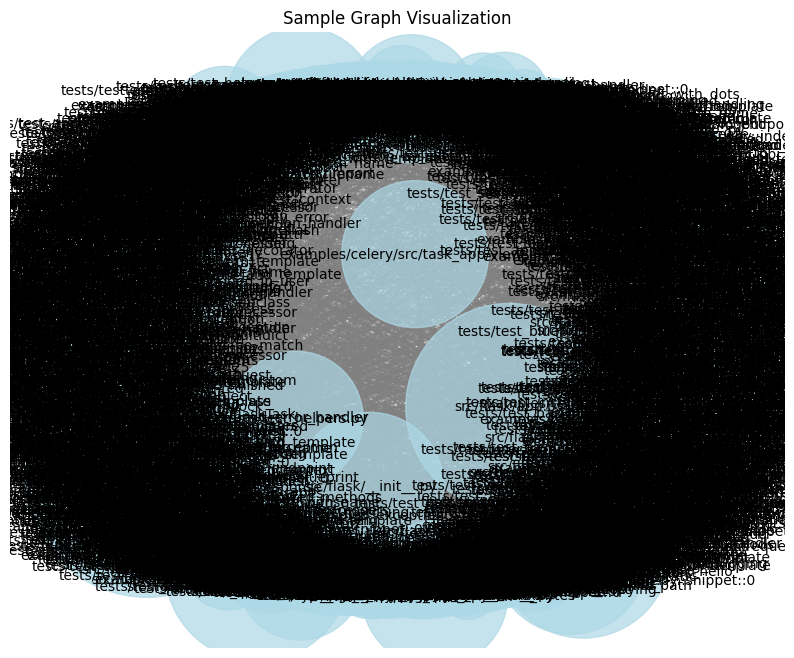

In [9]:

class GraphVisualizer:
    def __init__(self, graph: nx.Graph):
        self.graph = graph
        self.pos = None
        
    def set_layout(self, layout_type: str = 'spring', **layout_params) -> None:
        """
        Set the layout for the graph visualization.
        
        Args:
            layout_type: Type of layout ('spring', 'circular', 'kamada_kawai', 
                        'random', 'shell', 'spectral')
            layout_params: Additional parameters for the layout algorithm
        """
        layout_funcs = {
            'spring': nx.spring_layout,
            'circular': nx.circular_layout,
            'kamada_kawai': nx.kamada_kawai_layout,
            'random': nx.random_layout,
            'shell': nx.shell_layout,
            'spectral': nx.spectral_layout
        }
        
        if layout_type not in layout_funcs:
            raise ValueError(f"Unsupported layout type. Choose from: {list(layout_funcs.keys())}")
            
        self.pos = layout_funcs[layout_type](self.graph, **layout_params)
    
    def _get_node_colors(self) -> Dict[str, str]:
        """Extract node colors from graph attributes or generate defaults."""
        colors = {}
        for node in self.graph.nodes():
            # Check for color in node attributes
            attrs = self.graph.nodes[node]
            if 'fillcolor' in attrs:
                colors[node] = attrs['fillcolor']
            elif 'color' in attrs:
                colors[node] = attrs['color']
            else:
                colors[node] = 'lightblue'  # default color
        return colors
    
    def _get_node_sizes(self) -> Dict[str, float]:
        """Extract or compute node sizes."""
        sizes = {}
        for node in self.graph.nodes():
            attrs = self.graph.nodes[node]
            if 'size' in attrs:
                sizes[node] = attrs['size']
            else:
                # Default size based on node degree
                sizes[node] = 1000 * (1 + self.graph.degree(node) / 10)
        return sizes
    
    def _get_edge_colors(self) -> Dict[Tuple[str, str], str]:
        """Extract edge colors from graph attributes or generate defaults."""
        colors = {}
        for u, v in self.graph.edges():
            edge_data = self.graph.get_edge_data(u, v)
            if 'color' in edge_data:
                colors[(u, v)] = edge_data['color']
            else:
                colors[(u, v)] = 'gray'  # default color
        return colors
    
    def _get_node_labels(self) -> Dict[str, str]:
        """Extract node labels from graph attributes."""
        labels = {}
        for node in self.graph.nodes():
            attrs = self.graph.nodes[node]
            if 'label' in attrs:
                labels[node] = attrs['label']
            else:
                labels[node] = str(node)
        return labels
    
    def _get_edge_labels(self) -> Dict[Tuple[str, str], str]:
        """Extract edge labels from graph attributes."""
        labels = {}
        for u, v in self.graph.edges():
            edge_data = self.graph.get_edge_data(u, v)
            if 'label' in edge_data:
                labels[(u, v)] = edge_data['label']
        return labels

    def visualize(self, 
                 figsize: Tuple[int, int] = (12, 8),
                 node_size: Optional[Dict[str, float]] = None,
                 node_color: Optional[Dict[str, str]] = None,
                 edge_color: Optional[Dict[Tuple[str, str], str]] = None,
                 with_labels: bool = True,
                 font_size: int = 8,
                 title: Optional[str] = None,
                 show_edge_labels: bool = True,
                 alpha: float = 0.7,
                 save_path: Optional[str] = None) -> None:
        """
        Visualize the graph with customizable options.
        
        Args:
            figsize: Size of the figure (width, height)
            node_size: Dictionary mapping nodes to their sizes
            node_color: Dictionary mapping nodes to their colors
            edge_color: Dictionary mapping edges to their colors
            with_labels: Whether to show node labels
            font_size: Size of the font for labels
            title: Title of the graph
            show_edge_labels: Whether to show edge labels
            alpha: Transparency of nodes
            save_path: Path to save the visualization (if None, displays instead)
        """
        if self.pos is None:
            self.set_layout('spring')
            
        plt.figure(figsize=figsize)
        
        # Get or use provided node attributes
        node_colors = node_color if node_color is not None else self._get_node_colors()
        node_sizes = node_size if node_size is not None else self._get_node_sizes()
        edge_colors = edge_color if edge_color is not None else self._get_edge_colors()
        
        # Draw nodes
        nx.draw_networkx_nodes(self.graph, self.pos,
                             node_color=[node_colors[node] for node in self.graph.nodes()],
                             node_size=[node_sizes[node] for node in self.graph.nodes()],
                             alpha=alpha)
        
        # Draw edges
        for (u, v) in self.graph.edges():
            nx.draw_networkx_edges(self.graph, self.pos,
                                 edgelist=[(u, v)],
                                 edge_color=edge_colors.get((u, v), 'gray'),
                                 alpha=0.5)
        
        # Add labels if requested
        if with_labels:
            labels = self._get_node_labels()
            nx.draw_networkx_labels(self.graph, self.pos, labels,
                                  font_size=font_size)
        
        # Add edge labels if requested
        if show_edge_labels:
            edge_labels = self._get_edge_labels()
            if edge_labels:
                nx.draw_networkx_edge_labels(self.graph, self.pos,
                                           edge_labels=edge_labels,
                                           font_size=font_size-2)
        
        if title:
            plt.title(title)
        
        plt.axis('off')
        
        if save_path:
            plt.savefig(save_path, bbox_inches='tight', dpi=300)
            plt.close()
        else:
            plt.show()

# Example usage:
'''
# Create a sample graph
G = nx.Graph()
G.add_nodes_from([
    (1, {'fillcolor': 'lightblue', 'label': 'Node 1'}),
    (2, {'fillcolor': 'lightgreen', 'label': 'Node 2'}),
    (3, {'fillcolor': 'lightred', 'label': 'Node 3'})
])
G.add_edges_from([
    (1, 2, {'color': 'blue', 'label': 'Edge 1-2'}),
    (2, 3, {'color': 'red', 'label': 'Edge 2-3'})
])
'''
# Create visualizer and display graph
visualizer = GraphVisualizer(G)
visualizer.set_layout('spring', k=2)  # k controls the spacing between nodes
visualizer.visualize(
    figsize=(10, 8),
    font_size=10,
    title="Sample Graph Visualization",
)


### Make Database


In [12]:
'''
db = ArangoClient(hosts="https://d2eeb8083350.arangodb.cloud:8529").db(username="root", password="cUZ0YaNdcwfUTw6VjRny", verify=True)

print(db)
'''

<StandardDatabase _system>


In [20]:
'''
G_adb = nxadb.Graph(
    name="FlaskRepv1",
    db=db,
    incoming_graph_data=G,
    write_batch_size=50000 # feel free to modify
)

print(G_adb)
'''

[04:45:32 +0000] [INFO]: Graph 'FlaskRepv1' exists.
[04:45:33 +0000] [INFO]: Default node type set to 'FlaskRepv1_node'


Graph named 'FlaskRepv1' with 2328 nodes and 3435 edges


### Run from loaded database

In [87]:
db = ArangoClient(hosts="https://d2eeb8083350.arangodb.cloud:8529").db(username="root", password="cUZ0YaNdcwfUTw6VjRny", verify=True)

print(db)

<StandardDatabase _system>


In [ ]:
G_adb = nxadb.Graph(
    name="FlaskRepv1",
    db=db,
    #incoming_graph_data=G,
    #write_batch_size=50000 # feel free to modify
)

print(G_adb

In [14]:
arango_graph = ArangoGraph(db)

In [15]:
os.environ["MISTRAL_API_KEY"]="jJAuJZkjVcy2ynUhan375sHNviHiBeJU"

In [16]:
from langchain_mistralai import ChatMistralAI

llm = ChatMistralAI(
    model="mistral-large-latest",
    temperature=0,
    max_retries=2,
    # other params...
)
llm.invoke("Hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 4, 'total_tokens': 13, 'completion_tokens': 9}, 'model': 'mistral-large-latest', 'finish_reason': 'stop'}, id='run-e90a1ceb-16cb-479b-bb2e-d7eea6a4bb34-0', usage_metadata={'input_tokens': 4, 'output_tokens': 9, 'total_tokens': 13})

In [17]:

@tool
def text_to_nx_algorithm_to_text(query):
    """This tool is available to invoke a NetworkX Algorithm on
    the ArangoDB Graph. You are responsible for accepting the
    Natural Language Query, establishing which algorithm needs to
    be executed, executing the algorithm, and translating the results back
    to Natural Language, with respect to the original query.

    If the query (e.g traversals, shortest path, etc.) can be solved using the Arango Query Language, then do not use
    this tool.
    """
    llm = ChatMistralAI(
        model="mistral-large-latest",
        temperature=0,
        max_retries=2,
        # other params...
    )
    ######################
    print("1) Generating NetworkX code")

    text_to_nx = llm.invoke(f"""
    I have a NetworkX Graph called `G_adb`. It has the following schema: {arango_graph.schema}

    I have the following graph analysis query: {query}.

    Generate the Python Code required to answer the query using the `G_adb` object.
    
    It should give code so that is gives ALL the necessary contents that use this part of the code in terms of ALL nested imports. Consider the nested directories and sub-directory informations as well.

    Be very precise on the NetworkX algorithm you select to answer this query. Think step by step.

    Only assume that networkx is installed, and other base python dependencies.

    Always set the last variable as `FINAL_RESULT`, which represents the answer to the original query.

    Only provide python code that I can directly execute via `exec()`. Do not provide any instructions.

    Make sure that `FINAL_RESULT` stores a short & consice answer. Avoid setting this variable to a long sequence.

    Your code:
    """).content

    text_to_nx_cleaned = re.sub(r"^```python\n|```$", "", text_to_nx, flags=re.MULTILINE).strip()
    
    print('-'*10)
    print(text_to_nx_cleaned)
    print('-'*10)

    ######################

    print("\n2) Executing NetworkX code")
    global_vars = {"G_adb": G_adb, "nx": nx}
    local_vars = {}

    try:
        exec(text_to_nx_cleaned, global_vars, local_vars)
        text_to_nx_final = text_to_nx
    except Exception as e:
        print(f"EXEC ERROR: {e}")
        return f"EXEC ERROR: {e}"

        # TODO: Consider experimenting with a code corrector!
        attempt = 1
        MAX_ATTEMPTS = 3

        # while attempt <= MAX_ATTEMPTS
            # ...

    print('-'*10)
    FINAL_RESULT = local_vars["FINAL_RESULT"]
    print(f"FINAL_RESULT: {FINAL_RESULT}")
    print('-'*10)

    ######################

    print("3) Formulating final answer")

    nx_to_text = llm.invoke(f"""
        I have a NetworkX Graph called `G_adb`. It has the following schema: {arango_graph.schema}

        I have the following graph analysis query: {query}.

        I have executed the following python code to help me answer my query:

        ---
        {text_to_nx_final}
        ---

        The `FINAL_RESULT` variable is set to the following: {FINAL_RESULT}.

        Based on my original Query and FINAL_RESULT, generate a short and concise response to
        answer my query.
        
        Your response:
    """).content

    return nx_to_text

In [21]:
text_to_nx_algorithm_to_text("What is the use of has_level_handler in the codebase. Give appropriate context")

1) Generating NetworkX code
----------
import networkx as nx

# Assuming G_adb is already defined and populated with the graph data

# Step 1: Identify nodes that contain 'has_level_handler'
def find_nodes_with_keyword(graph, keyword):
    nodes_with_keyword = []
    for node, data in graph.nodes(data=True):
        if 'type' in data and data['type'] == 'file':
            if keyword in data.get('directory', ''):
                nodes_with_keyword.append(node)
    return nodes_with_keyword

# Step 2: Find all nodes connected to the identified nodes
def find_connected_nodes(graph, nodes):
    connected_nodes = set()
    for node in nodes:
        connected_nodes.update(nx.all_neighbors(graph, node))
    return connected_nodes

# Step 3: Extract relevant information from the connected nodes
def extract_node_info(graph, nodes):
    node_info = []
    for node in nodes:
        node_data = graph.nodes[node]
        node_info.append({
            'node_id': node,
            'type': node_da

"Based on the analysis of the graph `G_adb`, there are no nodes that contain the keyword 'has_level_handler' in their directory. Consequently, there are no connected nodes to analyze further. Therefore, the term 'has_level_handler' does not appear in the codebase as per the current graph data."

In [22]:
print(G_adb)

Graph named 'FlaskRepv1' with 2328 nodes and 3435 edges


In [23]:
arango_graph.schema

{'Graph Schema': [{'graph_name': 'FlaskRepv1',
   'edge_definitions': [{'edge_collection': 'FlaskRepv1_node_to_FlaskRepv1_node',
     'from_vertex_collections': ['FlaskRepv1_node'],
     'to_vertex_collections': ['FlaskRepv1_node']}]}],
 'Collection Schema': [{'collection_name': 'FlaskRepv1_node',
   'collection_type': 'document',
   'document_properties': [{'name': '_key', 'type': 'str'},
    {'name': '_id', 'type': 'str'},
    {'name': '_rev', 'type': 'str'},
    {'name': 'type', 'type': 'str'},
    {'name': 'file_index', 'type': 'int'},
    {'name': 'directory', 'type': 'str'}],
   'example_document': {'_key': '0',
    '_id': 'FlaskRepv1_node/0',
    '_rev': '_jRJHi4G---',
    'type': 'file',
    'file_index': 1,
    'directory': 'docs'}},
  {'collection_name': 'FlaskRepv1_node_to_FlaskRepv1_node',
   'collection_type': 'edge',
   'edge_properties': [{'name': '_key', 'type': 'str'},
    {'name': '_id', 'type': 'str'},
    {'name': '_from', 'type': 'str'},
    {'name': '_to', 'type':